In [7]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [8]:
import xarray as xr
from tqdm import tqdm
import pandas as pd
import multiprocessing as mp
import geopandas as gpd

import matplotlib.pyplot as plt  # plotting library
import cartopy.crs as ccrs  # Projections list

In [9]:
START_YEAR = 1960
END_YEAR = 2022
MONTH = [str(i + 1).zfill(2) for i in range(12)]
years = range(START_YEAR, END_YEAR + 1)
year_month = [(y, m) for y in years for m in MONTH]
len(year_month)

756

In [10]:
year_month[0]
year_month[-1]

(1960, '01')

(2022, '12')

In [11]:
def convert_crs(ds):
    ds.rio.write_crs("epsg:4326", inplace=True)
    ds.coords["longitude"] = (ds.coords["longitude"] + 180) % 360 - 180
    ds = ds.sortby(ds.longitude)
    return ds

## Tout ensemble pour aller plus vite

In [12]:
frontieres_europe = gpd.clip(
    gpd.read_file("NUTS_RG_20M_2021_4326.shp"), (-10, 35, 35, 70), keep_geom_type=False
)
frontieres_france_metro = gpd.read_file("FRA_adm0.shp")
frontieres_france_toute_circo_detail = gpd.read_file(
    "france-circonscriptions-legislatives-2012.shp"
)
frontieres_france_toute_circo_exterieurs = (
    frontieres_france_toute_circo_detail.geometry.unary_union
)
frontieres_france_toute_circo = gpd.GeoDataFrame(
    geometry=[frontieres_france_toute_circo_exterieurs],
    crs=frontieres_france_toute_circo_detail.crs,
)

In [13]:
# frontieres_france_toute_circo_detail.plot(figsize=(30,20))

In [14]:
HAUTE_MARNE = frontieres_france_toute_circo_detail.query(
    "code_dpt=='52' and num_circ=='1'"
)
# HAUTE_MARNE.plot()

In [15]:
def process_one_month(
    year,
    month,
    frontieres_europe,
    frontieres_france_metro,
    frontieres_france_toute_circo,
):
    file = f"/mnt/data-out/datacirco/data/meteo/ERA5/monthly_dl/{year}-{month}_global.netcdf"
    ds_global = xr.open_dataset(file)
    # Conversion des coordonnées
    era = convert_crs(ds_global)
    # Filtrage sur l'Europe
    era_masked_eu = era.rio.clip(
        frontieres_europe.geometry.values, frontieres_europe.crs, all_touched=True
    )
    # Filtrage sur la France
    era_masked_fr = era.rio.clip(
        frontieres_france_toute_circo.geometry.values,
        frontieres_france_toute_circo.crs,
        all_touched=True,
    )
    era_masked_fr_metro = era_masked_eu.rio.clip(
        frontieres_france_metro.geometry.values,
        frontieres_france_metro.crs,
        all_touched=True,
    )
    jours_mois = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    nb_jour_mois = jours_mois[int(month) - 1]
    # Monde
    ds_global_t2m_celcius_world = era.t2m - 273.15  # K to Celcius
    ds_global_tp_mm_world = era.tp * 1_000 * nb_jour_mois  # m to mm and dy to month
    # Europe
    ds_global_t2m_celcius_eu = era_masked_eu.t2m - 273.15  # K to Celcius
    ds_global_tp_mm_eu = era_masked_eu.tp * 1_000 * nb_jour_mois  # m to mm
    # France Metropolitaine
    ds_global_t2m_celcius_fr_metro = era_masked_fr_metro.t2m - 273.15  # K to Celcius
    ds_global_tp_mm_fr_metro = era_masked_fr_metro.tp * 1_000 * nb_jour_mois  # m to mm
    # France toutes circos
    ds_global_t2m_celcius_fr = era_masked_fr.t2m - 273.15  # K to Celcius
    ds_global_tp_mm_fr = era_masked_fr.tp * 1_000 * nb_jour_mois  # m to mm

    return {
        "year": year,
        "month": month,
        "global": {
            "temp_celcius": float(ds_global_t2m_celcius_world.mean().values),
            "precipitation_mm": float(ds_global_tp_mm_world.mean().values),
        },
        "europe": {
            "data-temp": ds_global_t2m_celcius_eu,
            "data-rain": ds_global_tp_mm_eu,
            "temp_celcius": float(ds_global_t2m_celcius_eu.mean().values),
            "precipitation_mm": float(ds_global_tp_mm_eu.mean().values),
        },
        "france": {
            # Les données sont pour toutes les circos
            "data-temp": ds_global_t2m_celcius_fr,
            "data-rain": ds_global_tp_mm_fr,
            # Le chiffre de moyenne est celui de la France Metro
            "temp_celcius": float(ds_global_t2m_celcius_fr_metro.mean().values),
            "precipitation_mm": float(ds_global_tp_mm_fr_metro.mean().values),
        },
    }

In [16]:
def convert_to_pandas(ds):
    df = ds.to_dataframe().dropna().reset_index().drop(["spatial_ref"], axis=1)
    df.rename(
        {"time": "date", "t2m": "temperature", "tp": "precipitation"},
        axis=1,
        inplace=True,
    )
    return df


def prepare_pandas(data):
    df_temp = convert_to_pandas(data["france"]["data-temp"])
    df_rain = convert_to_pandas(data["france"]["data-rain"])
    df = pd.merge(df_temp, df_rain, how="inner", on=["date", "latitude", "longitude"])
    assert len(df) == len(df_temp)
    df["annee"] = df["date"].dt.year
    df["mois"] = df["date"].dt.month
    df = df[
        [
            "longitude",
            "latitude",
            "date",
            "annee",
            "mois",
            "precipitation",
            "temperature",
        ]
    ]
    return df


def extract_data(data):
    world = {
        "year": data["year"],
        "month": data["month"],
        "temp_celcius": data["global"]["temp_celcius"],
        "precipitation_mm": data["global"]["precipitation_mm"],
    }
    europe = {
        "year": data["year"],
        "month": data["month"],
        "temp_celcius": data["europe"]["temp_celcius"],
        "precipitation_mm": data["europe"]["precipitation_mm"],
    }
    france = {
        "year": data["year"],
        "month": data["month"],
        "temp_celcius": data["france"]["temp_celcius"],
        "precipitation_mm": data["france"]["precipitation_mm"],
    }
    # Sauve les données ERA5 sur le périmètre des circonscriptions
    df = prepare_pandas(data)
    path_to_csv_file = f"/mnt/data-out/datacirco/data/meteo/ERA5/FR_circo_ERA5_{data['year']}-{data['month']}.csv"
    df.to_csv(path_to_csv_file, sep=",", index=False)
    return {
        "world": world,
        "europe": europe,
        "france": france,
    }

In [17]:
data = process_one_month(
    "2022",
    "08",
    frontieres_europe,
    frontieres_france_metro,
    frontieres_france_toute_circo,
)
extract_data(data)

{'world': {'year': '2022',
  'month': '08',
  'temp_celcius': 8.057548522949219,
  'precipitation_mm': 77.92333221435547},
 'europe': {'year': '2022',
  'month': '08',
  'temp_celcius': 19.691184997558594,
  'precipitation_mm': 73.42276763916016},
 'france': {'year': '2022',
  'month': '08',
  'temp_celcius': 21.93572998046875,
  'precipitation_mm': 55.331932067871094}}

Modèle de sortie: "longitude", "latitude", "date", "annee", "mois", "precipitation", "temperature"

In [18]:
world = []
europe = []
france = []


def store_data(data):
    world.append(data["world"])
    europe.append(data["europe"])
    france.append(data["france"])

In [19]:
def process_and_save(year_month):
    # print(year_month)
    year, month = year_month
    data = process_one_month(
        year,
        month,
        frontieres_europe,
        frontieres_france_metro,
        frontieres_france_toute_circo,
    )
    data = extract_data(data)
    return data

In [20]:
%%time
data = process_and_save(("2012", "08"))
store_data(data)
# print(world)
# print(europe)
# print(france)

CPU times: user 1.06 s, sys: 0 ns, total: 1.06 s
Wall time: 1.07 s


In [21]:
%%time
len(year_month)


def worker(year_and_month, return_dict):
    """worker function
    Args:
        year_and_month : year and month in the form "YYYY-MM"
    """
    data = process_and_save((year_and_month[0:4], year_and_month[5:7]))
    return_dict[year_and_month] = {
        "world": data["world"],
        "europe": data["europe"],
        "france": data["france"],
    }


manager = mp.Manager()
return_dict = manager.dict()
jobs = []
for k in tqdm(year_month):
    p = mp.Process(target=worker, args=(str(k[0]) + "-" + str(k[1]), return_dict))
    jobs.append(p)
    p.start()

for proc in tqdm(jobs):
    proc.join()

100%|██████████| 756/756 [00:55<00:00, 13.74it/s] 

CPU times: user 1.38 s, sys: 6.33 s, total: 7.71 s
Wall time: 3min 30s


In [28]:
def prepare_monthly_mean(data) -> pd.DataFrame:
    df = pd.DataFrame(data)
    df["date_str"] = df["year"].astype(str) + df["month"].astype(str)
    df["date"] = pd.to_datetime(df["date_str"], format="%Y%m")
    df.rename(
        {
            "year": "annee",
            "month": "mois",
            "temp_celcius": "temperature",
            "precipitation_mm": "precipitation",
        },
        axis=1,
        inplace=True,
    )
    df = df[["date", "annee", "mois", "precipitation", "temperature"]]
    return df


def save_csv(df, area):
    path_to_csv_file = (
        f"/mnt/data-out/datacirco/data/meteo/ERA5/ERA5_moyenne_mensuelle_{area}.csv"
    )
    df.to_csv(path_to_csv_file, sep=",", index=False)


world = []
europe = []
france = []
for d in tqdm(return_dict):
    # print("---------------------------")
    # print(d)
    # print(return_dict.get(d))
    world.append(return_dict.get(d).get("world"))
    europe.append(return_dict.get(d).get("europe"))
    france.append(return_dict.get(d).get("france"))

df_world = prepare_monthly_mean(world)
df_europe = prepare_monthly_mean(europe)
df_france = prepare_monthly_mean(france)

save_csv(df_world, "monde")
save_csv(df_europe, "europe")
save_csv(df_france, "france")

df_world.head(3)
df_europe.head(3)
df_france.head(3)

100%|██████████| 756/756 [00:00<00:00, 6075.22it/s]


date annee mois  precipitation  temperature
0 1969-08-01  1969   08      77.334290     6.817653
1 1960-04-01  1960   04      66.019455     3.516760
2 1960-09-01  1960   09      71.453796     5.866583

date annee mois  precipitation  temperature
0 1969-08-01  1969   08      70.041595    17.718603
1 1960-04-01  1960   04      57.524025     6.948993
2 1960-09-01  1960   09      64.600433    13.136512

date annee mois  precipitation  temperature
0 1969-08-01  1969   08      79.047279    17.844975
1 1960-04-01  1960   04      40.619743     9.435205
2 1960-09-01  1960   09     101.290192    14.245567

# Tests

In [22]:
data = process_one_month(
    "2022",
    "08",
    frontieres_europe,
    frontieres_france_metro,
    frontieres_france_toute_circo,
)

In [23]:
data["global"]

{'temp_celcius': 8.057548522949219, 'precipitation_mm': 77.92333221435547}

<GeoAxes: title={'center': 'spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

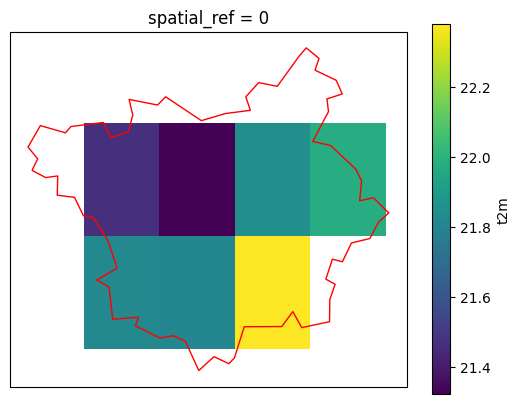

In [24]:
t2m_tavg = data["france"]["data-temp"].mean(dim="time")
t2m_tavg = t2m_tavg.rio.clip(HAUTE_MARNE.geometry.values, HAUTE_MARNE.crs)
ax = plt.axes(projection=ccrs.Robinson())
t2m_tavg.plot(ax=ax)  # , transform=ccrs.PlateCarree()
HAUTE_MARNE.plot(ax=ax, edgecolor="red", color="none")

<GeoAxes: title={'center': 'spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

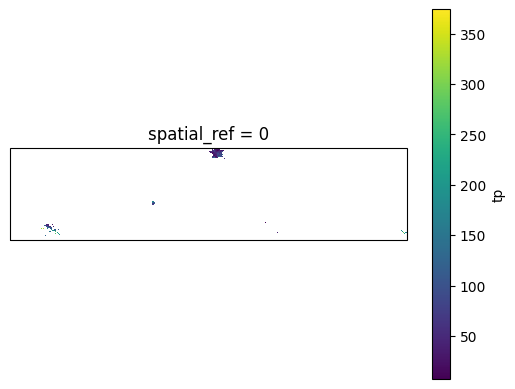

In [25]:
t2m_tavg = data["france"]["data-rain"].mean(dim="time")
ax = plt.axes(projection=ccrs.Robinson())
t2m_tavg.plot(ax=ax)  # , transform=ccrs.PlateCarree()
frontieres_france_toute_circo.boundary.plot(ax=ax, edgecolor="red", color="none")

In [ ]:
europe_boundaries = gpd.read_file("NUTS_RG_20M_2021_4326.shp")
europe_boundaries.plot()
europe_crop = gpd.clip(europe_boundaries, (-10, 35, 35, 70), keep_geom_type=False)
europe_crop.plot()

NameError: name 'europe_crop' is not defined

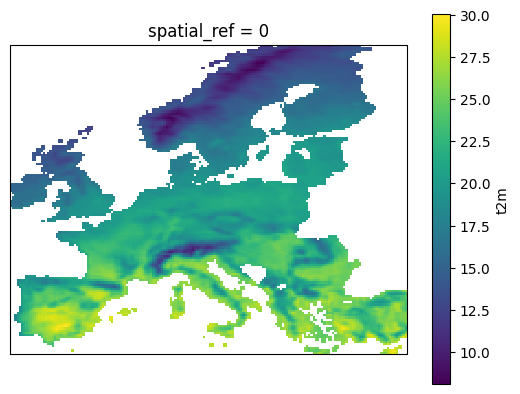

In [26]:
t2m_tavg = data["europe"]["data-temp"].mean(dim="time")
ax = plt.axes(projection=ccrs.Robinson())
t2m_tavg.plot(ax=ax)  # , transform=ccrs.PlateCarree()
europe_crop.plot(ax=ax, edgecolor="red", color="none")

NameError: name 'europe_crop' is not defined

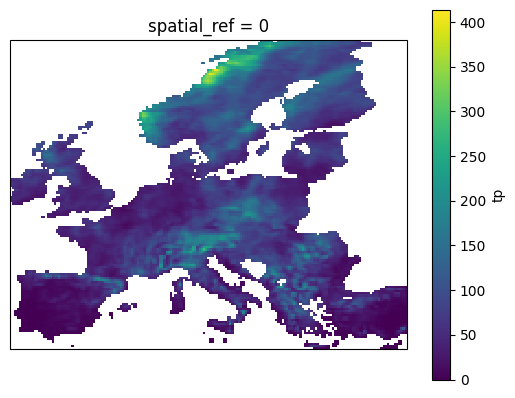

In [27]:
t2m_tavg = data["europe"]["data-rain"].mean(dim="time")
ax = plt.axes(projection=ccrs.Robinson())
t2m_tavg.plot(ax=ax)  # , transform=ccrs.PlateCarree()
europe_crop.plot(ax=ax, edgecolor="red", color="none")

In [134]:
data["europe"]["data-rain"].min()

<xarray.DataArray 'tp' ()>
array(0., dtype=float32)
Coordinates:
    spatial_ref  int64 0

In [135]:
year_month[-1]

(2022, '12')

In [136]:
ds = data["europe"]["data"]
ds

KeyError: 'data'

In [137]:
ds.max()

NameError: name 'ds' is not defined

In [74]:
frontieres_france_toute_circo_detail.geometry

0      POLYGON ((-0.45495 44.95342, -0.40932 44.94761...
1      POLYGON ((5.80529 45.20620, 5.75468 45.19679, ...
2      POLYGON ((3.05875 50.78071, 3.08067 50.77286, ...
3      POLYGON ((-0.61065 44.82247, -0.60305 44.81848...
4      MULTIPOLYGON (((-61.49348 16.35364, -61.45097 ...
                             ...                        
561    MULTIPOLYGON (((-63.09622 18.06261, -63.08109 ...
562    MULTIPOLYGON (((-176.25085 -13.29059, -176.224...
563    MULTIPOLYGON (((-150.65198 -17.66457, -150.628...
564    MULTIPOLYGON (((-153.03842 -22.64486, -153.033...
565    MULTIPOLYGON (((-149.58139 -17.54487, -149.582...
Name: geometry, Length: 566, dtype: geometry

In [138]:
from rioxarray.exceptions import NoDataInBounds

t2m_tavg = data["france"]["data-temp"].mean(dim="time")
shape_before = None


def check_data(row):
    global shape_before
    try:
        t2m_tavg.rio.clip([row.geometry], HAUTE_MARNE.crs, all_touched=True)
    except NoDataInBounds:
        print(f"PAS DE DONNEE pour {row.nom_dpt}, circo={row.num_circ}")
        shape_before = row.geometry
        t2m_tavg.rio.clip([row.geometry.envelope], HAUTE_MARNE.crs, all_touched=True)


_ = frontieres_france_toute_circo_detail.apply(check_data, axis=1)

In [141]:
# # gpd.GeoDataFrame(geometry=[shape_before.buffer(2)], crs=frontieres_france_toute_circo_detail.crs).plot()
# file = f'/mnt/data-out/datacirco/data/meteo/ERA5/monthly_dl/2022-06_global.netcdf'
# ds_global = xr.open_dataset(file)
# # Conversion des coordonnées
# era = convert_crs(ds_global)
# era_crop = era.t2m.rio.clip(shape.envelope.buffer(0.5), HAUTE_MARNE.crs, all_touched=True)
# shape = gpd.GeoDataFrame(geometry=[shape_before], crs=frontieres_france_toute_circo_detail.crs)
# fig, ax1 = plt.subplots()
# #shape.envelope.buffer(1).plot(ax=ax1, color = 'slategrey')
# era_crop.plot(ax = ax1)
# shape.plot(ax = ax1, color = 'red')

<GeoAxes: title={'center': 'spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

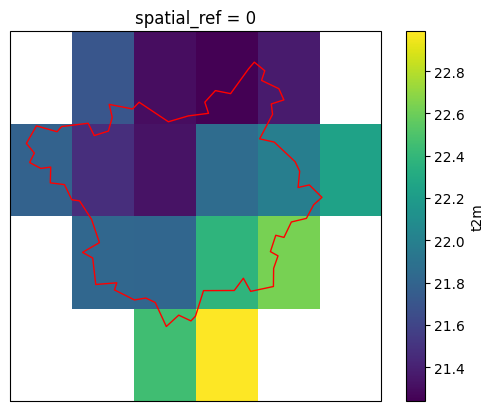

In [140]:
t2m_tavg = data["france"]["data-temp"].mean(dim="time")
t2m_tavg = t2m_tavg.rio.clip(
    HAUTE_MARNE.geometry.values, HAUTE_MARNE.crs, all_touched=True
)
ax = plt.axes(projection=ccrs.Robinson())
t2m_tavg.plot(ax=ax)  # , transform=ccrs.PlateCarree()
HAUTE_MARNE.plot(ax=ax, edgecolor="red", color="none")

In [191]:
prepare_pandas(data)

longitude  latitude       date  annee  mois  precipitation  temperature
0          1.75     51.00 2022-08-01   2022     8       0.749201    19.813751
1          2.00     51.00 2022-08-01   2022     8       0.684336    20.427765
2          2.25     51.00 2022-08-01   2022     8       0.540011    20.646729
3          2.50     51.00 2022-08-01   2022     8       0.353519    20.705994
4          2.75     51.00 2022-08-01   2022     8       0.445955    20.533142
...         ...       ...        ...    ...   ...            ...          ...
1974    -143.50    -27.75 2022-08-01   2022     8       7.222839    19.125641
1975    -143.25    -27.75 2022-08-01   2022     8       8.130964    19.119080
1976    -143.75    -28.00 2022-08-01   2022     8       6.467149    19.007141
1977    -143.50    -28.00 2022-08-01   2022     8       6.968237    18.993958
1978    -143.25    -28.00 2022-08-01   2022     8       8.101772    18.992310

[1979 rows x 7 columns]

# Exploration

## Moyenne Monde

In [6]:
def process_one_month_global(year, month):
    file = f"/mnt/data-out/datacirco/data/meteo/ERA5/monthly_dl/{year}-{month}_global.netcdf"
    ds_global = xr.open_dataset(file)
    ds_global_t2m_celcius = ds_global.t2m - 273.15  # K to Celcius
    ds_global_tp_mm = ds_global.tp * 1_000  # m to mm

    return {
        "year": year,
        "month": month,
        "temp_celcius": float(ds_global_t2m_celcius.mean().values),
        "precipitation_mm": float(ds_global_tp_mm.mean().values),
    }

In [ ]:
process_one_month("2022", "08")

In [ ]:
monthly_means = []
for year, month in tqdm(year_month):
    monthly_means.append(process_one_month_global(year, month))

In [ ]:
df_yearly = pd.DataFrame(monthly_means)
df_yearly["year-month"] = df_yearly["year"].astype(str) + "-" + df_yearly["month"]
df_yearly["date"] = pd.to_datetime(df_yearly["year-month"], format="%Y-%m")
df_yearly

In [ ]:
df_yearly = df_yearly.groupby(["year"])[["temp_celcius", "precipitation_mm"]].mean()
df_yearly = df_yearly.reset_index()

In [ ]:
df_yearly.plot(x="year", y="temp_celcius")

In [ ]:
df_yearly.plot(x="year", y="precipitation_mm")

## Europe

In [ ]:
#!wget https://gisco-services.ec.europa.eu/distribution/v2/nuts/shp/NUTS_RG_20M_2021_4326.shp.zip

In [ ]:
#!unzip NUTS_RG_20M_2021_4326.shp.zip

In [ ]:
#   scale_x_continuous(limits = c(-10, 35)) +
#  scale_y_continuous(limits = c(35, 65))

In [ ]:
year = "2022"
month = "08"
file = (
    f"/mnt/data-out/datacirco/data/meteo/ERA5/monthly_dl/{year}-{month}_global.netcdf"
)
ds_global = xr.open_dataset(file)

# era = ds_global.rio.write_crs("EPSG:4326", inplace=True)
era = convert_crs(ds_global)

In [ ]:
ax = plt.axes(projection=ccrs.Robinson())
era.t2m.mean(dim="time").plot(ax=ax)

In [ ]:
europe_crop.crs

In [ ]:
era_masked = era.rio.clip(europe_crop.geometry.values, europe_crop.crs)

In [ ]:
def print_border(ds):
    print(
        f"{ds.latitude.max().values} {ds.latitude.min().values} {ds.longitude.max().values} {ds.longitude.min().values}"
    )


print_border(era)
print_border(era_masked)

In [ ]:
# Keep only countries borders
europe_crop = europe_crop.query("LEVL_CODE == 0")

In [ ]:
ax = plt.axes(projection=ccrs.Robinson())
era_masked.t2m.mean(dim="time").plot(ax=ax)  # , transform=ccrs.PlateCarree()
europe_crop.plot(ax=ax, edgecolor="red", color="none")

In [ ]:
era_masked.t2m.mean()

In [ ]:
ds_global_t2m_celcius = ds_global.t2m - 273.15  # K to Celcius
ds_global_tp_mm = ds_global.tp * 1_000  # m to mm

In [ ]:
def process_one_month_mask(year, month, mask_map):
    file = f"/mnt/data-out/datacirco/data/meteo/ERA5/monthly_dl/{year}-{month}_global.netcdf"
    ds_global = xr.open_dataset(file)
    # Conversion des coordonnées
    era = convert_crs(ds_global)
    # Filtrage sur l'Europe
    era_masked = era.rio.clip(mask_map.geometry.values, mask_map.crs)
    # Calcul de la moyenne
    ds_global_t2m_celcius = era_masked.t2m - 273.15  # K to Celcius
    ds_global_tp_mm = era_masked.tp * 1_000  # m to mm

    return {
        "year": year,
        "month": month,
        "temp_celcius": float(ds_global_t2m_celcius.mean().values),
        "precipitation_mm": float(ds_global_tp_mm.mean().values),
    }, era_masked

In [ ]:
mean, data = process_one_month_mask("2022", "08", europe_crop)
mean

In [ ]:
data.t2m.plot()

In [ ]:
data.tp.plot()

## France

Ici, nous voulons garder toutes les données pour être sûr de bien avoir des données par circo. Et ça semble  rapide de faire les requêtes dans PostGIS.

In [24]:
# Frontière circo https://www.data.gouv.fr/en/datasets/carte-des-circonscriptions-legislatives-2012-et-2017/

In [ ]:
frontieres_france_metro = gpd.read_file("FRA_adm0.shp")

In [ ]:
mean, data = process_one_month_mask("2022", "08", france)
mean

In [ ]:
tp_tavg = data.tp.mean(dim="time")
ax = plt.axes(projection=ccrs.Robinson())
tp_tavg.plot(ax=ax)  # , transform=ccrs.PlateCarree()
france.plot(ax=ax, edgecolor="red", color="none")

In [ ]:
t2m_tavg = data.t2m.mean(dim="time")
ax = plt.axes(projection=ccrs.Robinson())
t2m_tavg.plot(ax=ax)  # , transform=ccrs.PlateCarree()
france.plot(ax=ax, edgecolor="red", color="none")